<a href="https://colab.research.google.com/github/semnouws/PRA3024/blob/main/PRA3024_2324_Cosmology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='deepskyblue'>Cosmology MCMC notebook </font>

## <font color='deepskyblue'>Preliminaries</font>

In [8]:
# Install required packages (if not available on server)
try:
  import getdist
except:
  !pip install getdist
  import getdist

# Load required packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate as integrate

# import pylab
import getdist, IPython, time
from numpy import random

# from IPython.display import Image
from getdist import plots, MCSamples, loadMCSamples

# just for printing! calculations should be performed with machine precision
%precision 3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.1/826.1 kB 7.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for getdist: filename=getdist-1.4.7-py3-none-any.whl size=810432 sha256=72b118ed1cfb548580bd1682a2b77e6ea32c9afc09bd3dd59f4d16d5bac81210
  Stored in directory: /root/.cache/pip/wheels/11/3e/8d/93c9494b4587d95165f805b376a4c7ed3ae670eb3cf7397389
Successfully built getdist


'%.3f'


<font color='tomato'>
(NB: The equations you'll directly need to build your code are those $\boxed{\text{with a box around}}$)
</font>

## <font color='deepskyblue'>The $\Lambda$CDM Model</font>

The Lambda-Cold-Dark-Matter ($\Lambda$CDM) Model is our concordance cosmological model. It postulates a Universe that behaves according to **General Relativity**, filled with **baryons** (protons, neutrons - the stuff we and stars are made of!), **Cold Dark Matter (CDM)** and a **Cosmological Constant** $\Lambda$.

The expansion of the Universe is best described in terms of the **scale factor** $a$ (the "radius" of the Universe, conventionally set to 1 today) and the **Hubble rate** $H$. While photons (light rays) travel in the expanding universe they get redshifted, and this redshift is directly related to the size of the Universe when the photon was emitted compared to today:

$$ \frac{\lambda_{\rm obs}}{\lambda_{\rm em}} \equiv 1 + z_{\rm em} = \frac{1}{a_{\rm em}}$$


In the $\Lambda$CDM model (and at late enough times), this additionally simplifies to

$$
\begin{gathered}
\boxed{
H^2 = H_0^2\left[\Omega_\Lambda + \Omega_m (1+z)^3 + \Omega_k (1+z)^2\right]
}
\\
\boxed{
\Omega_m + \Omega_\Lambda + \Omega_k = 1
}
\end{gathered}
\tag{1}
$$

$H_0$ is the value of the Hubble rate *today*, and the parameters $\Omega_m$, $\Omega_\Lambda$ and $\Omega_k$ are dimensionless quantities indicating how much of the present expansion of the Universe is due to (non-relativistic) matter, cosmological constant $\Lambda$, and spatial curvature $k$. Note that the three $\Omega$'s are *not independent* (their sum is 1) and that we grouped together the contribution of baryons and CDM,

$$
\Omega_m = \Omega_{\rm CDM} + \Omega_{\rm b}
$$

and that we have evidence that independent evidence that $\Omega_b \approx 5$\%. NB: only $\Omega_m \geq 0$ makes physical sense, while in principle both $\Omega_\Lambda$ and $\Omega_k$ can be negative.

The present Hubble rate is conventionally parametrised in terms of the dimensionless $h$:

$$
\boxed{
  H_0 \equiv 100\,h\,\frac{\rm km}{\rm s\,Mpc}
}
\tag{2}
$$

where Mpc = Megaparsec and [parsec](https://en.wikipedia.org/wiki/Parsec) equals to about $3.26$ light years or $3.086 \cdot 10^{16}$ m.

In essence, these equations give us the relation between *what exists in the Universe* and *how the Universe expanded*. Measure one, I can tell you the other. This is precisely what we aim to do!

Time to define the function $H(z)$. Don't forget to include the useful parameters as arguments of the function, and to define `parsec`.

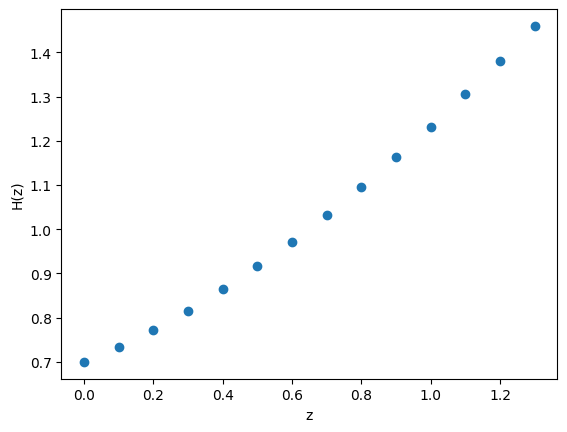

In [10]:
# Hubble rate: look at equations (1) and (2) for the definition!
mpc = 3.08*10**16 #m
omega_l = 0.7
omega_m = 0.3

H0 = 0.7

def Hubble(z, H0, omega_l, omega_m):
      omega_k = 1 - omega_m - omega_l
      H = H0 * np.sqrt((omega_l + omega_m*(1+z)**3 + omega_k*(1+z)**2))
      return H

# plot to check
%matplotlib inline
omega_l = 0.7
omega_m = 0.3
H0 = 0.7

zs = np.arange(0, 1.4, 0.1)
Hs = []
for z in zs:
  Hs += [Hubble(z, H0, omega_l, omega_m)]

plt.scatter(zs, Hs)
plt.xlabel('z')
plt.ylabel('H(z)')
plt.show()

Test for the function

## <font color='deepskyblue'>Supernovae Ia</font>

In order to track the expansion of the Universe, we will look at Supernovae type Ia observations. SNIa are formed when a *white dwarf* accretes matter from a companion until it reaches a critical mass of about $1.44 M_\odot$ (solar masses), after which it explodes **at always the same luminosity** $L_{\rm SN}$. Therefore, the observed [magnitude](https://en.wikipedia.org/wiki/Magnitude_(astronomy)) is only a function of their [**luminosity distance**](https://en.wikipedia.org/wiki/Distance_measures_(cosmology)) from Earth, defined as the ratio of the intrinsic luminosity $L_{\rm SNIa}$ and the measured *surface brightness* $\Phi$ (energy per unit time per unit area)

$$ d_L\equiv \frac{L_{\rm SN}}{4\pi \Phi} $$

We can express the luminosity distance in terms of the Hubble rate:

$$
\boxed{
d_L(z) = \frac{c}{H_0}(1+z) \times
\begin{cases}
    \cfrac{1}{\sqrt{\Omega_k}} \,\sinh\left(\sqrt{\Omega_k}\,D(z)\right) & \Omega_k > 0
    \\[.5em]
    D(z) & \Omega_k = 0
    \\[.5em]
    \cfrac{1}{\sqrt{-\Omega_k}} \,\sin\left(\sqrt{-\Omega_k}\,D(z)\right) & \Omega_k < 0
\end{cases}
\qquad\qquad
D(z) \equiv H_0\int_0^z \frac{{\rm d}Z}{H(Z)}
}
\tag{3}
$$

where $c$ is the speed of light: $c \simeq 2.998 \cdot 10^{5}$ km/s.

Clearly, there exists a relation between $d_L(z)$ and $H(z)$, so the luminosity distance is a useful measure of the Universe expansion history.
In practice, however, the actual observable for [Supernovae Type Ia](https://en.wikipedia.org/wiki/Type_Ia_supernova) (or SNIa) is the [distance modulus](https://en.wikipedia.org/wiki/Distance_modulus) $\mu$, defined as the difference between the *apparent magnitude* $m$ and the *absolute magnitude* $M$:

$$
\boxed{
\mu(z) \equiv m(z) - M \equiv 5 \log_{10} \frac{d_L(z)}{10\,\text{pc}}
}
\tag{4}
$$

We can create the function `dL(z, h, Omega_m, Omega_Lambda)`. You can also pass the function `Hubble` as an argument: `dL(z, Hubble, Omega_m, Omega_Lambda)`. Additionally, you can create $D(z)$ for your convenience.

Note that you need to integrate the function $H(z)$, so write your own quick-and-easy numerical integrator, for example implementing the [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule) or your favourite alternative, or [look up the pre-written methods](https://docs.scipy.org/doc/scipy/tutorial/integrate.html). Make sure it returns $d_L$ in parsecs and that it uses $H_0$ measured in units of 100 km/s/Mpc (which we called $h$).

In [11]:
c = 2.998e5
mpc = 3.08e16 #m
pc = mpc/(10**6)
omega_k = 1 - omega_m - omega_l

# Integrate 1/H from x = 0 to x = z
def D(z, H0, omega_l, omega_m): # Yes, you can pass a function as argument!
    # This is how you integrate with integrate.quad;
    # (...)[0] gives the result of the integral; (...)[1] is the error estimate; see manual for details
    return H0 * integrate.quad(lambda x: 1/Hubble(z, H0, omega_l, omega_m), 0, z)[0]

# Let's just print a sample result
print(D(1, 67, 0.3, 0.7))

def dL(z, H0, omega_l, omega_m): # luminosity distance, use eq.(3)
    omega_k = 1 - omega_m - omega_l
    if (omega_k > 0) :
      mult = (1/np.sqrt(omega_k))*np.sinh(np.sqrt(omega_k)*D(z, H0, omega_l, omega_m))
    if (omega_k < 0) :
      mult = (1/np.sqrt(-omega_k))*np.sinh(np.sqrt(-omega_k)*D(z, H0, omega_l, omega_m))
    if (omega_k == 0) :
      mult = D(z, H0, omega_l, omega_m)
    result_dL = (c*H0)*(1+z)*mult
    return result_dL

print(dL(1, 67, 0.3, 0.7))

def mu(z, H0, omega_l, omega_m): # distance modulus -- use eq.(4)
    return 5*np.log10(dL(z, H0, omega_l, omega_m)%(10*pc))

print (mu(1, 67, 0.3, 0.7))

0.41169348479630913
16539044.703419086
36.092552105279985


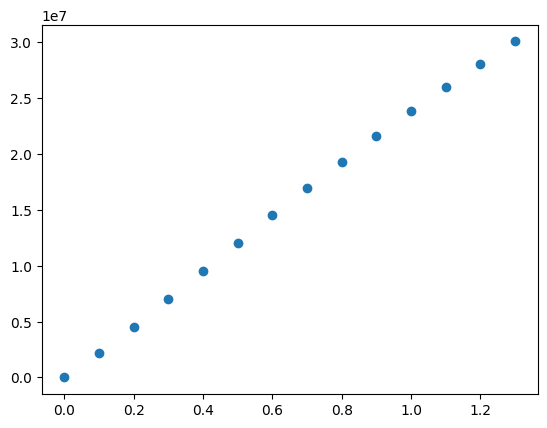

In [12]:
#test for dL function

omega_l = 0.7
omega_m = 0.3
H0 = 70

zs = np.arange(0, 1.4, 0.1)
dLs = []
for z in zs :
  dLs += [dL(z, H0, omega_l, omega_m)]

plt.scatter(zs, dLs)


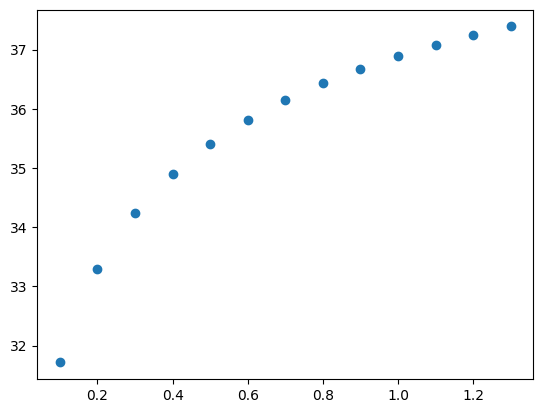

In [13]:
#test mu function
omega_l = 0.7
omega_m = 0.3
H0 = 70

zs = np.arange(0.1, 1.4, 0.1)
mus= []
for z in zs :
  mus+= [mu(z, H0, omega_l, omega_m)]

plt.scatter(zs, mus)

## <font color='deepskyblue'>The Union2.1 Compilation</font>

Our source of data is from [Union2.1](http://supernova.lbl.gov/Union/). It is a collection of $580$ SNIa, each observation is comprised of redshift $z$
Our goal today is to use SNIa measurements to constrain the parameters ($h, \Omega_\Lambda, \Omega_m$).

In essence, we can calculate for each redshift the theoretical value of $\mu$ using this equation with the expression for $d_L(z)$ and our model of choice $H(z)$ -- note that we will need to perform a numerical integral! -- and compare this value with observations. A different model would amount to changing the theoretical value of $H(z)$.

Let us start by importing and plotting the data:

In [14]:
dataloc = "http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt"

# Read in data as numpy array.
# Format is [name, redshift, magnitude, magnitude error, and another number?]
data = np.genfromtxt(dataloc)

# Print the first line as an example. (Note that genfromtxt turns the names into 'Not A Number')
display(data[0])

array([      nan, 2.849e-02, 3.535e+01, 2.239e-01, 1.284e-01])

In [15]:
# Extract the redshifts (zs), distance modulus (dist_mod) and magnitude estimated errors (err_dist_mod)
# Data are in columns, so we either slice it by columns: arr[:,n]...
zs = data[:,1] # redshift

# ...or transpose the array and then slice by row: arr_transposed[n]
distance_modulus = data.T[2] # distance modulus
error_distance_modulus = data.T[3] # errors on distance modulus = sigmas

In [16]:
# Let's look at the data, just for fun.
# We can look both at the raw data (distance modulus) or calculate the luminosity distance
# Note that Numpy allows us to manipulate whole arrays at once with something like:
#     array_2 = some_function_of(array_1)

# luminosity distance in Mpc
luminosity_distance_pc = 1.E-5 * 10.**(distance_modulus / 5.)

<ErrorbarContainer object of 3 artists>

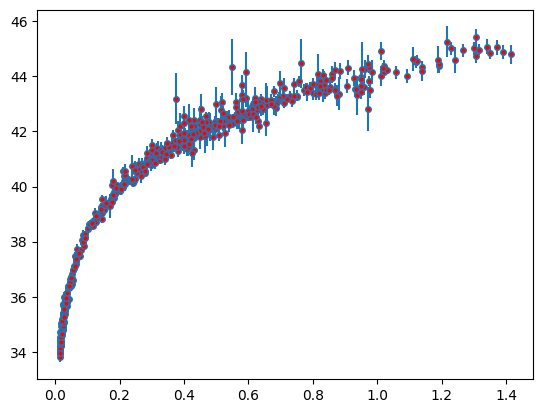

In [17]:
# Recommendation: you might want to try your functions here, and check that for Omega_m = 0.3 and Omega_L = 0.7 you get a decent match to the data
%matplotlib inline

# Plot distance modulus versus redshift (original data)
plt.grid
plt.errorbar(zs, distance_modulus, yerr=error_distance_modulus , fmt='o', markersize=4, markerfacecolor='red')


## <font color='deepskyblue'>Bayes' Theorem: Likelihood, Prior, Posterior (and Evidence...)</font>

The **conditional probability of A given that B is true** is denoted with $P(A|B)$ (read: *probability of A given B*).
Did A happen? Then B has probability $P(B|A)$ of happening.

[**Bayes' Theorem**](https://en.wikipedia.org/wiki/Bayes%27_theorem) is simply a reflection of the symmetry of the concept of joint probability:

$$
P(A|B)P(B) = P(B|A)P(A)
$$

In physics, our goal is often to determine how likely the values of some parameters $\theta$ are, given how well they reproduce the data $D$.
We write Bayes' theorem in the following equivalent form:

$$
P(\theta | D) = \frac{P(D|\theta)P(\theta)}{P(D)}
$$

The various terms conventionally take the names:

$$
\begin{aligned}
P(\theta | D) & && \text{Posterior}
\\
P(D | \theta)& && \text{Likelihood}
\\
P(\theta) & && \text{Prior}
\\
P(D) & && \text{Evidence}
\end{aligned}
$$

### <font color='deepskyblue'>Prior</font>

The *prior* quantifies our degree of prior belief in the model parameters. It can contain the results of previous experiments, or theoretical considerations (for instance, that certain parameters cannot be negative, etc.).

We can have *strong priors* about something - the Sun still existing at night, see the comic below - or not.
When we do *not* have compelling prior knowledge about a parameter, we generally use a *non-informative* prior probability distribution, most often related to the [uniform distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution)

You may sometimes hear that "the prior doesn't matter". While this is not strictly true, it is however true that in many instances the *likelihood* depends more dramatically on the parameters and will have a dominating contribution to the posterior. You are more than welcome to try different priors for the model parameters and see if and how your results change.

### <font color='deepskyblue'>Likelihood</font>

The measure of how well our model reproduces the data is the **likelihood** $\mathcal L$. For normal (=Gaussian), uncorrelated data $\mu_i$ with errors $\sigma_i$ ($i = \{1,580\}$), the likelihood is related to the famous [**chi-squared**](https://en.wikipedia.org/wiki/Chi-square_distribution) via

$$
P(D | \theta) \equiv \mathcal L = \exp\left(-\frac{\chi^2}{2}\right)
\qquad
\qquad
\boxed{
\chi^2 \equiv \sum_{i=1}^{580} \frac{\left(\mu_i^{(\rm theor)} - \mu_i^{(\rm obs)}\right)^2}{\sigma_i^2}
}
\tag{5}
$$

A *high likelihood* corresponds to a *low chi squared*.

In principle, we could attack the problem brute-force: create a grid of values for $h$, $\Omega_m$, $\Omega_\Lambda$, calculate the likelihood for each combination, and create a profile for the likelihood.

In practical cases, however, this is not only sub-optimal but sometimes **impossible**. Think of complicated models with 20+ free parameters (this is not unheard of, by the way). Even a very coarse grained grid of 100 values for each parameter would result in more than $10^{40}$ (!!!) different parameter combination to be tested. You can probably understand why this is undesirable.

### <font color='deepskyblue'>Evidence</font>

This is the tricky bit. The evidence, which is "*the probability of observing certain data*", is not something that is easy to evaluate or interpret. This looks like a serious limitation to finding the:


### <font color='deepskyblue'>Posterior</font>

What does the data tell us about the model parameters? The answer is the *posterior probability distribution*, often (but not necessarily) expressed as (average $\pm$ standard deviation)

$$
\theta_i = \bar\theta_i \pm \sigma_i
$$

In other words, the posterior tells us how likely it is for the model parameters to have certain values, *given that we observe the data* $D$.

*This is the final goal of our analysis!*

<br>

![title](http://1.bp.blogspot.com/-tTx4HDejSww/ULcTeK9_V_I/AAAAAAAAA8g/PCYOH-eXGbk/s1600/frequentists_vs_bayesians.png)
![title](https://i.redd.it/5r0hwixt0m931.jpg)

## <font color='deepskyblue'>Markov-Chain Monte Carlo</font>

Markov-Chain Monte Carlo techniques are a class of methods to sample a probability distribution $P(x)$ - in our case $P(\theta | D)$ - provided that we can calculate a density $\mathcal F(x)$ **that is proportional to it** - in our case $P(\theta)P(D|\theta)$ = likelihood $\times$ prior. Among these, a very popular one is the [**Metropolis-Hastings**](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm, which is what we will use.

Schematically, the algorithm works as follows:
* Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and calculate the $\mathcal F_{\rm old}$
* Propose a new set of parameters $\theta_{\rm prop}$, calculate the new corresponding $\mathcal F_{\rm prop}$. How you propose the new parameters is not essential as long as the probability of going from one set of parameters to the next is the same as the inverse: $P(\theta_a \to \theta_b) = P(\theta_b \to \theta_a)$. For this, we normally take Gaussian displacements with some (relatively small) standard deviation.
* Compare the new and old likelihoods-priors:
    * If $\mathcal F_{\rm prop} > \mathcal F_{\rm old}$, accept the step: $\theta_{\rm new} = \theta_{\rm prop}$
    * Otherwise, accept with probability $P_{\rm accept} = \mathcal F_{\rm prop}/\mathcal F_{\rm old}$
* If accepted, $\theta_{\rm new} = \theta_{\rm prop}$ and record the step; otherwise, $\theta_{\rm new} = \theta_{\rm old}$ (no re-recording)
* Update $\theta_{\rm old} = \theta_{\rm new}$
* Repeat

The MC chain keeps going until the desired number of steps or, ideally, when a suitable convergence test, like for example the [Gelman-Rubin test](https://bookdown.org/rdpeng/advstatcomp/monitoring-convergence.html), is satisfied.
Today we will just set a limit to the total number of steps, but please feel free to implement and test your favourite convergence test!

Looking at equation (5), you can convince yourself that
$$
\frac{\mathcal L_a}{\mathcal L_b} = \exp\left(\frac{\chi_b^2 - \chi_a^2}{2}\right)
$$

(This is useful because $\chi^2$ can be large, so we want to avoid the likelihoods evaluating to `0.` -- computers don't like dividing by zero, unfortunately)


* <font color="deepskyblue"> Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and the corresponding chi squared $\chi_{\rm old}^2$ (to be clear, for us this implies calculating a series of 580 integrals and comparing each with the observed values) </font>
* <font color="deepskyblue"> Propose new parameters $\theta_{\rm prop}$ and calculate the corresponding chi squared $\chi_{\rm prop}^2$</font>
* <font color="deepskyblue"> Draw a random number $r \in [0,1]$</font>
* <font color="deepskyblue"> Accept the step if
$$
r < \exp\left(\frac{\chi_{\rm old}^2 - \chi_{\rm prop}^2}{2}\right) \frac{P(\theta)_{\rm prop}}{P(\theta)_{\rm old}}
$$</font>
    * <font color="deepskyblue"> If accepted, update $\theta_{\rm old} = \theta_{\rm prop}$</font>
    * <font color="deepskyblue">If you want, you can keep a record of the best fit (lowest $\chi^2$), but this is not the specific purpose of MCMC! We are exploring the parameter space and sampling a _posterior distribution_, not just finding the best fit</font>
* <font color="deepskyblue"> Record the step - including **re-recording** if the step was not accepted! </font>
* <font color="deepskyblue"> Repeat</font>

The following code only accepts chi2 if it the value is a better fit than the last.

In [35]:
# You don't actually need to write your data on a file (you could just store it in some np.array)
# but it tends to be a good idea, so that you run a good, long MCMC once, and then you can do all the
# analysis later on at any time, without having to produce the data again

# Choose your favourite filename
MCfile = "MC_Chain_SNIa.txt"
file = open(MCfile, "w")

# A few thousand *ACCEPTED* steps is a decent ballpark for the minimum length of your MCMC chain
# NB: start with a few hundreds, see if everything works as expected, and then commit to a longer run (>= 5000 steps)
N_steps = 5000
chi2_current_best = 99999999
chi2_list = []
# Start from some very bad values, to show that the MCMC works anyway!
# (making sure you don't divide by zero anywhere...)
omega_m = 0.1
omega_l = 0.1
H0 = 0.1

# Main MCMC loop
for i in range(N_steps):
    chi2_current = 0
    # Displacement of parameters at each step
    d_omega_m = omega_m + np.random.normal(0, 0.1)
    d_omega_l = omega_l + np.random.normal(0, 0.1)
    d_H0 = H0 + np.random.normal(0, 0.1)

    if (d_omega_m < 0.0) :
      continue
    if (d_H0 < 0.0) :
      continue

    print ("h = {}, omega_m = {}, omega_l = {}".format(d_omega_m, d_omega_l, d_H0))

    # loop over all datapoints
    for i in range(len(zs)) :
        mu_model = mu(zs[i], d_H0, d_omega_l, d_omega_m)
        chi2 = (mu_model - distance_modulus[i])**2 / error_distance_modulus[i]**2
        chi2_current += chi2

    # Check for NaN
    if np.isnan(chi2) : continue

    print("Chi2 current = {}".format(chi2_current))
    print(f"  Iteration {i}: = chi2 {chi2}")

     # Accept or reject the new parameters based on the chi-square value
    if chi2_current < chi2_current_best:
        print("           This is a better point!")
        print("  ")
        # Accept the new parameters
        omega_m = d_omega_m
        omega_l = d_omega_l
        H0 = d_H0
        chi2_current_best = chi2_current
        chi2_list += [chi2_current]
    else:
        print("  ")
        continue

file.close();

h = 0.059386794613591025, omega_m = 0.1396555124810019, omega_l = 0.10041369956427453
Chi2 current = 8616025.206117373
  Iteration 579: = chi2 7601.2320613864495
           This is a better point!
  
h = 0.09572012661818963, omega_m = 0.21363405847372818, omega_l = 0.08888075313071725
Chi2 current = 8823255.433027958
  Iteration 579: = chi2 7777.897842146244
  
h = 0.11324134737884226, omega_m = 0.13574595969923414, omega_l = 0.12258423413332828
Chi2 current = 8280374.746764534
  Iteration 579: = chi2 7323.187193388783
           This is a better point!
  
h = 0.013145427378659452, omega_m = 0.13142515637843755, omega_l = 0.2825338431524371
Chi2 current = 6866476.274655779
  Iteration 579: = chi2 6044.951665701581
           This is a better point!
  
h = 0.06561728108654136, omega_m = 0.10338610946284099, omega_l = 0.194987555539642
Chi2 current = 7488031.185581202
  Iteration 579: = chi2 6615.788159489345
  
h = 0.08392411175199095, omega_m = 0.21459746875758534, omega_l = 0.11561892

<ipython-input-10-27d5c8eb67ff>:10: RuntimeWarning: invalid value encountered in sqrt
  H = H0 * np.sqrt((omega_l + omega_m*(1+z)**3 + omega_k*(1+z)**2))
<ipython-input-11-373e978aa2a6>:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return H0 * integrate.quad(lambda x: 1/Hubble(z, H0, omega_l, omega_m), 0, z)[0]


Streaminguitvoer ingekort tot de laatste 5000 regels.
           This is a better point!
  
h = 1.8584144475817825, omega_m = 3.49443915598248, omega_l = 6.155718633710408
h = 1.8139747638425447, omega_m = 3.409994698427836, omega_l = 6.091633322955646
Chi2 current = 1984659.815314429
  Iteration 579: = chi2 14.727480796134598
           This is a better point!
  
h = 1.7390242099689845, omega_m = 3.3918527993349903, omega_l = 6.0343228034311185
h = 2.020863774087779, omega_m = 3.4060714951882636, omega_l = 6.008555133580483
Chi2 current = 2296243.6941963076
  Iteration 579: = chi2 1312.654605371178
  
h = 1.9114149434474583, omega_m = 3.3953283041790985, omega_l = 6.10853816100956
Chi2 current = 2178593.9846231495
  Iteration 579: = chi2 913.3812147414116
  
h = 1.743047670734723, omega_m = 3.5060366058740753, omega_l = 6.274511933592589
h = 1.657009105741808, omega_m = 3.5725106919589655, omega_l = 6.106753834852742
h = 1.6611754339984375, omega_m = 3.2954814900472935, omega_l = 6.25

This code includes the Metropolis-Hastings acceptance criterion by comparing the current chi-square value (chi2_current) with the previous best chi-square value (chi2_current_best). If the new chi-square value is better or if a randomly generated number is less than the acceptance probability, the new parameters are accepted. Otherwise, they are rejected, and the old parameters are kept

In [ ]:
# Choose your favourite filename
MCfile = "MC_Chain_SNIa.txt"
file = open(MCfile, "w")

# Initial parameter values
omega_m = 0.1
omega_l = 0.1
H0 = 0.1

# Number of MCMC steps
N_steps = 5000

# Initialize the best chi-square value
chi2_current_best = 99999999

# Initialize the list to store chi-square values
chi2_list = []

# Main MCMC loop
for i in range(N_steps):
    # Displacement of parameters at each step
    d_omega_m = omega_m + np.random.normal(0, 0.1)
    d_omega_l = omega_l + np.random.normal(0, 0.1)
    d_H0 = H0 + np.random.normal(0, 0.1)

    # Check for non-physical parameter values
    if d_omega_m < 0.0 or d_H0 < 0.0:
        continue

    # Calculate the chi-square for the new parameters
    chi2_current = 0
    for j in range(len(zs)):
        mu_model = mu(zs[j], d_H0, d_omega_l, d_omega_m)
        chi2 = (mu_model - distance_modulus[j])**2 / error_distance_modulus[j]**2
        chi2_current += chi2

    # Accept or reject the new parameters based on the Metropolis-Hastings criterion
    if chi2_current < chi2_current_best or np.random.rand() < np.exp((chi2_current_best - chi2_current)):
        # Accept the new parameters
        omega_m = d_omega_m
        omega_l = d_omega_l
        H0 = d_H0
        chi2_current_best = chi2_current
        chi2_list += [chi2_current]
        print("Accepted: Chi2 = ", chi2_current)
    else:
        # Reject the new parameters
        print("Rejected: Chi2 = ", chi2_current)

file.close()


Accepted: Chi2 =  7854388.695572735
Accepted: Chi2 =  6956009.094598326
Accepted: Chi2 =  6706951.120305542
Accepted: Chi2 =  6268250.264331432
Accepted: Chi2 =  5875989.854288831
Accepted: Chi2 =  5860892.352840363
Rejected: Chi2 =  6547018.802574377
Accepted: Chi2 =  5756421.727869433
Accepted: Chi2 =  5576500.645693748
Accepted: Chi2 =  5510867.398642711
Rejected: Chi2 =  5516931.53141846
Rejected: Chi2 =  5520533.926912801
Rejected: Chi2 =  5593116.561204535
Accepted: Chi2 =  5432397.603970347
Rejected: Chi2 =  5573012.163508384
Rejected: Chi2 =  5455292.76968871
Rejected: Chi2 =  5510146.87112235
Accepted: Chi2 =  5383675.696982943
Accepted: Chi2 =  5335732.518090094
Rejected: Chi2 =  5396004.719260926
Accepted: Chi2 =  5193080.842116322
Accepted: Chi2 =  5098983.004456634
Rejected: Chi2 =  5254403.886620709
Rejected: Chi2 =  5200846.902469946
Rejected: Chi2 =  5213707.571665673
Accepted: Chi2 =  5038471.321611771
Accepted: Chi2 =  4957860.243259836
Accepted: Chi2 =  4889194.84345

<ipython-input-10-27d5c8eb67ff>:10: RuntimeWarning: invalid value encountered in sqrt
  H = H0 * np.sqrt((omega_l + omega_m*(1+z)**3 + omega_k*(1+z)**2))
<ipython-input-11-373e978aa2a6>:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return H0 * integrate.quad(lambda x: 1/Hubble(z, H0, omega_l, omega_m), 0, z)[0]


Rejected: Chi2 =  nan
Rejected: Chi2 =  3691191.5547842463
Accepted: Chi2 =  3661423.7629372547
Rejected: Chi2 =  3705961.9605919397
Accepted: Chi2 =  3655047.275617669
Accepted: Chi2 =  3578163.3362444425
Rejected: Chi2 =  3638419.006735164
Rejected: Chi2 =  3602214.164310495
Rejected: Chi2 =  3609845.5772586
Rejected: Chi2 =  3614467.7789393505
Rejected: Chi2 =  3611613.9848861257
Rejected: Chi2 =  3700634.4633091385
Rejected: Chi2 =  3618089.217284922
Rejected: Chi2 =  nan
Accepted: Chi2 =  3502548.651033813
Rejected: Chi2 =  3656125.5461717844
Rejected: Chi2 =  3541394.118986813
Rejected: Chi2 =  3720626.2598418565
Accepted: Chi2 =  3418844.2206125283
Rejected: Chi2 =  nan
Rejected: Chi2 =  3450581.9906493644
Rejected: Chi2 =  3491190.946961752
Rejected: Chi2 =  nan
Rejected: Chi2 =  nan
Rejected: Chi2 =  3474802.7101209513
Rejected: Chi2 =  nan
Rejected: Chi2 =  nan
Accepted: Chi2 =  3349552.2159716436
Rejected: Chi2 =  nan
Rejected: Chi2 =  3511133.668885537
Rejected: Chi2 =  nan

77
[7854388.695572735, 6956009.094598326, 6706951.120305542, 6268250.264331432, 5875989.854288831, 5860892.352840363, 5756421.727869433, 5576500.645693748, 5510867.398642711, 5432397.603970347, 5383675.696982943, 5335732.518090094, 5193080.842116322, 5098983.004456634, 5038471.321611771, 4957860.243259836, 4889194.843453988, 4821806.399910962, 4742106.628731147, 4582354.357710976, 4538926.581965128, 4485893.977421804, 4432168.320533515, 4422883.410189744, 4293346.127920922, 4246264.438285714, 4187834.054706165, 4106563.4238504153, 4077434.025240803, 4045065.0575866937, 4033258.3204400013, 4028436.378011429, 3880149.093580964, 3792458.6490944605, 3767737.202521136, 3717664.6553286007, 3689963.8572479943, 3673798.086244785, 3661423.7629372547, 3655047.275617669, 3578163.3362444425, 3502548.651033813, 3418844.2206125283, 3349552.2159716436, 3331087.5531197577, 3229863.6006737626, 3160733.8170797075, 3160668.801932184, 3093463.8246342316, 3072115.0346565056, 2968918.850001223, 2961746.6638

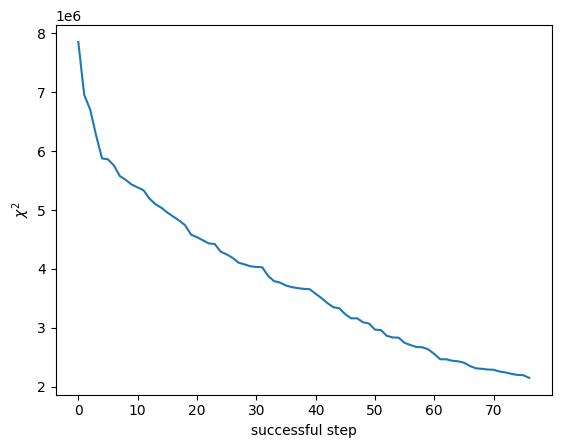

Best values: H0 = 4.9718389155452565 , omega_m = 1.762052281019006 , omega_l = 3.3535192749754157


In [42]:
print(len(chi2_list))
print(chi2_list)
plt.plot(chi2_list)
plt.xlabel("successful step")
plt.ylabel("$\chi^{2}$")
plt.show()

print("Best values: H0 = {} , omega_m = {} , omega_l = {}".format(H0, omega_m, omega_l))

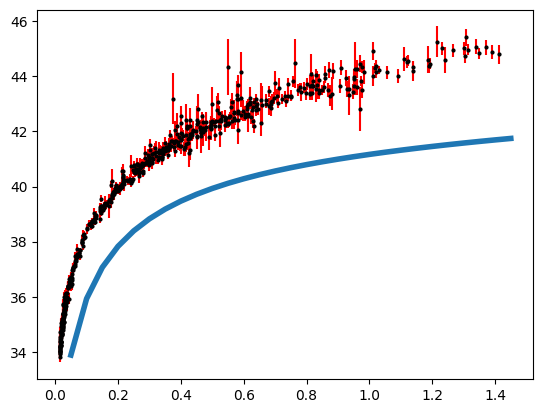

In [43]:
# Calculate the mean of the model values over the range of redshifts
modelzs = np.arange(0.05, 1.5, 0.05)
modelmus = [mu(z, omega_l, omega_m, H0) for z in modelzs]
model_mean = np.mean(modelmus)

# Calculate the mean of the data points over the same range of redshifts
data_mean = np.mean(distance_modulus)

# Scale the model amplitude to match the data amplitude
scaling_factor = data_mean / model_mean
scaled_modelmus = [mu_val * scaling_factor for mu_val in modelmus]

# Plot the error bars and the scaled model line
plt.errorbar(zs, distance_modulus,\
             yerr=error_distance_modulus,\
             fmt='o',\
             color='black',\
             ecolor='red',\
             markersize=2)

plt.plot(modelzs, scaled_modelmus, linewidth=4)

plt.show()


After completion of the programme, your MC chain will (*hopefully*) look something like this: (note the repeated entry!)

`#Omega_m  Omega_L  h`

`0.297     0.703    0.698`

`0.285     0.715    0.701`

`0.285     0.715    0.701`

`0.288     0.712    0.699`

`...`

## <font color='deepskyblue'>Plotting: GetDist</font>

We will do the plots with [`GetDist`](https://getdist.readthedocs.io/en/latest/plot_gallery.html).

The plot gallery contains a lot of useful examples, you should be able to read them fairly easily and see which applies to your situation. Look for both (triangle) plots and for parameter estimation.

Note that many `GetDist` functions require arguments of type `MCSamples`; make sure you convert your lists accordingly.

<font color='deepskyblue'>
Look at your results. Do you obtain $\Omega_\Lambda \neq 0$? To a high degree of significance?

If yes, then my dear friend, you have **DISCOVERED THE ACCELERATED EXPANSION OF THE UNIVERSE AND WON THE NOBEL PRIZE IN PHYSICS 2011!**
</font>

Removed no burn in
0.67  <  h  <  0.73  at  68 % CL
0.2  <  OmegaM  <  0.4  at  68 % CL
0.61  <  OmegaL  <  0.8  at  68 % CL
-0.14  <  Omegak  <  0.13  at  68 % CL




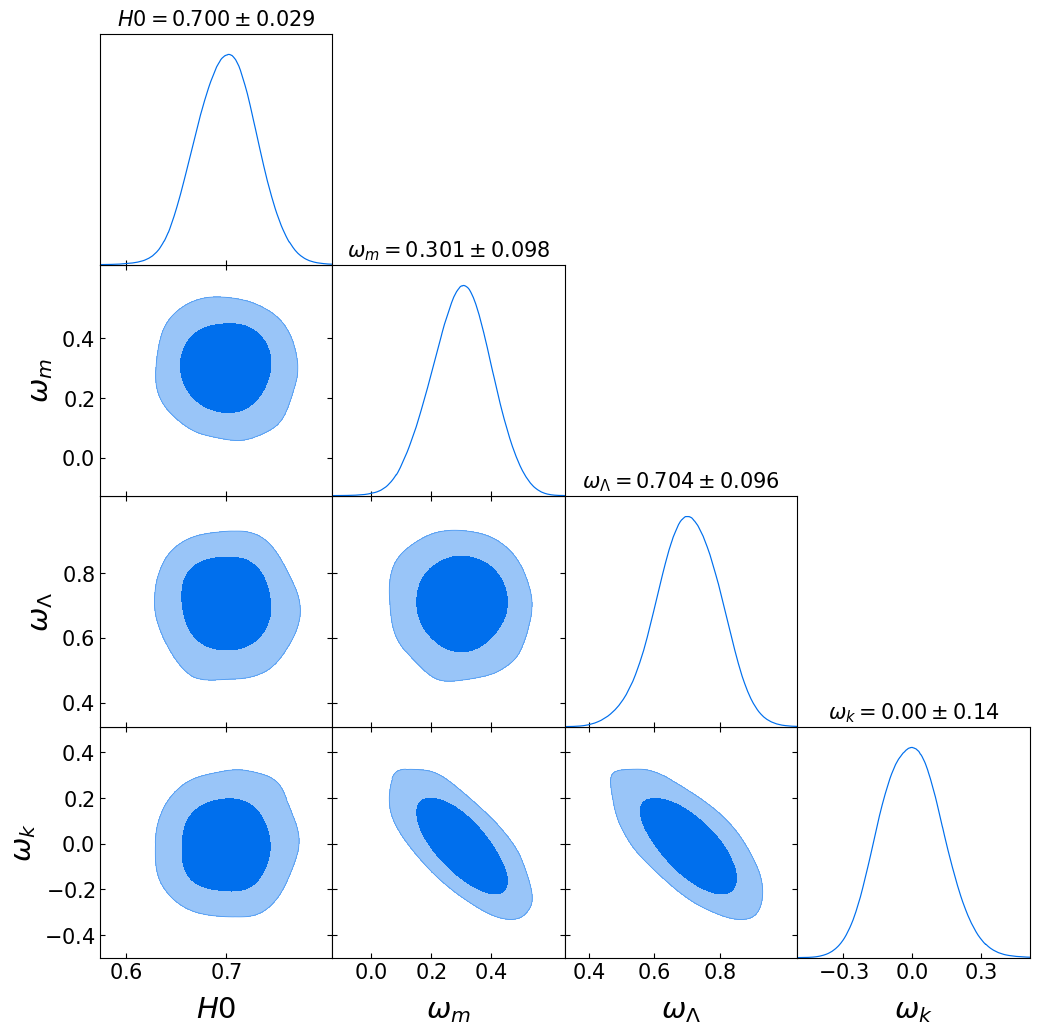

In [44]:
# These are just randomly generated values. YOU WILL HAVE TO USE THE RESULTS OF YOUR MCMC CHAIN!
# NB: when using your real data, consider removing some *burn-in* (look it up!)
H0, omega_m, omega_l = np.random.normal(0.7, 0.03, N_steps),\
                    np.random.normal(0.3, 0.1, N_steps), \
                    np.random.normal(0.7, 0.1, N_steps)

# You can easily create new np.arrays that are functions of other np.arrays
omega_k = 1. - omega_m - omega_l

# Let's define variable names and labels
my_labels = [r'H0', r'\omega_m', r'\omega_\Lambda', r'\omega_k']
my_names = ['h', 'OmegaM', 'OmegaL', 'Omegak']
my_dim = len(my_names) # The number of variables we're plotting

# This creates a higher-dimensional array with all our data, shaped in the appropriate way...
my_samples = np.transpose(np.reshape([H0, omega_m, omega_l, omega_k], (my_dim, len(H0))))

# ... to create an "MCSamples" data type, which GetDist can use
my_samples = MCSamples(samples = my_samples, labels = my_labels, names = my_names)

# The usual 1-sigma confidence level. You can change to 2- or 3-sigma if you want
conf_level = 0.6827

# This prints a table with the 1D posteriors (confidence levels)
for nam in my_names:
    print(round(my_samples.confidence(nam,(1.-conf_level)/2.,upper=False),2), \
          " < ", nam , " < ", round(my_samples.confidence(nam,(1.-conf_level)/2.,upper=True),2),\
          " at " , int(100*conf_level),"\b% CL")
print("\n")

#Triangle corner plot
j = plots.getSubplotPlotter(subplot_size=3)
j.settings.axes_labelsize = 22
j.settings.axes_fontsize = 16
j.triangle_plot(my_samples, filled = True, title_limit=1)

## <font color='deepskyblue'>Further Improvements</font>

There are many ways in which you can improve your code and/or your data visualisation. Some ideas, in random order:

* Modify your priors and compare your results. For instance:
  * Change to log-flat priors for $h$ and/or $\Omega_m$, namely displace them in log-space instead of linear space:
  $$
  \log(h_{\rm new}) = \log(h_{\rm old}) + \delta
  $$
  where $\delta$ a random variable of mean 0
  * Use priors from other cosmological probes, for example the [Planck 2018 results](https://arxiv.org/abs/1807.06209):
  $$
  \Omega_m = 0.315 \pm 0.007\,,~\dots
  $$
* Monitor acceptance ratio and $\chi^2$ as a function of step count
* Implement a Gelman-Rubin (or alternative) convergence test
* Change colours and other properties of your triangle plot
* Re-plot the data with your theoretical fits: you can try both your best fit, and some $1\sigma$ "error bars"
* Split your data in redshift bins and repeat the analysis for each bin individually.
<br> _(What do you notice? Which redshift bins give us the most accurate detection of the cosmological parameters?)_